In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in squirrel data
df = pd.read_csv('./squirrel_census.csv')
df.head(3)

,long,lat,unique_squirrel_id,hectare,shift,date,hectare_squirrel_number,age,primary_fur_color,highlight_fur_color,...,approaches,indifferent,runs_from,other_interactions,lat_long,zip_codes,community_districts,borough_boundaries,city_council_districts,police_precincts
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086),NaN,19,4,19,13
1,-73.957044,40.794851,37E-PM-1006-03,37E,PM,10062018,3,Adult,Gray,Cinnamon,...,False,False,True,me,POINT (-73.9570437717691 40.794850940803904),NaN,19,4,19,13
2,-73.976831,40.766718,2E-AM-1010-03,02E,AM,10102018,3,Adult,Cinnamon,NaN,...,False,True,False,NaN,POINT (-73.9768311751004 40.76671780725581),NaN,19,4,19,13


In [3]:
# Get rid of unnecessary features
df = df.drop(['lat_long',
              'highlight_fur_color',
              'combination_of_primary_and_highlight_color',
              'color_notes',
              'specific_location',
              'above_ground_sighter_measurement',
              'other_activities',
              'other_interactions',
              'zip_codes',
              'community_districts',
              'borough_boundaries',
              'city_council_districts',
              'police_precincts'], axis=1)
# Changes 'False' and 'True' to 0 and 1,respectively
df = (df * 1)

print('Shape: ',df.shape)
df.head()

Shape:  (3023, 23)


,long,lat,unique_squirrel_id,hectare,shift,date,hectare_squirrel_number,age,primary_fur_color,location,...,eating,foraging,kuks,quaas,moans,tail_flags,tail_twitches,approaches,indifferent,runs_from
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,-73.957044,40.794851,37E-PM-1006-03,37E,PM,10062018,3,Adult,Gray,Ground Plane,...,0,0,0,0,0,0,0,0,0,1
2,-73.976831,40.766718,2E-AM-1010-03,02E,AM,10102018,3,Adult,Cinnamon,Above Ground,...,0,0,0,0,0,0,0,0,1,0
3,-73.975725,40.769703,5D-PM-1018-05,05D,PM,10182018,5,Juvenile,Gray,Above Ground,...,0,0,0,0,0,0,0,0,0,1
4,-73.959313,40.797533,39B-AM-1018-01,39B,AM,10182018,1,NaN,NaN,Above Ground,...,0,0,1,0,0,0,0,0,0,0


In [4]:
# change data to category
for feat in ['unique_squirrel_id', 'hectare', 'shift', 'age', 'primary_fur_color', 'location']:
    df[feat] = df[feat].astype('category')

df.dtypes

long                        float64
lat                         float64
unique_squirrel_id         category
hectare                    category
shift                      category
date                          int64
hectare_squirrel_number       int64
age                        category
primary_fur_color          category
location                   category
running                       int64
chasing                       int64
climbing                      int64
eating                        int64
foraging                      int64
kuks                          int64
quaas                         int64
moans                         int64
tail_flags                    int64
tail_twitches                 int64
approaches                    int64
indifferent                   int64
runs_from                     int64
dtype: object

In [5]:
# Convert squirrel ID to integer
df.unique_squirrel_id = pd.Categorical(df.unique_squirrel_id)
df.unique_squirrel_id = df.unique_squirrel_id.cat.codes

df.head()

,long,lat,unique_squirrel_id,hectare,shift,date,hectare_squirrel_number,age,primary_fur_color,location,...,eating,foraging,kuks,quaas,moans,tail_flags,tail_twitches,approaches,indifferent,runs_from
0,-73.956134,40.794082,1912,37F,PM,10142018,3,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,-73.957044,40.794851,1902,37E,PM,10062018,3,Adult,Gray,Ground Plane,...,0,0,0,0,0,0,0,0,0,1
2,-73.976831,40.766718,1297,02E,AM,10102018,3,Adult,Cinnamon,Above Ground,...,0,0,0,0,0,0,0,0,1,0
3,-73.975725,40.769703,2565,05D,PM,10182018,5,Juvenile,Gray,Above Ground,...,0,0,0,0,0,0,0,0,0,1
4,-73.959313,40.797533,2045,39B,AM,10182018,1,NaN,NaN,Above Ground,...,0,0,1,0,0,0,0,0,0,0


# Defining the metric for friendliness

In [6]:
# tail_flags are a sign of aggression/frustration, not friendly
# tail_twitch are used for many different things, not helpful target
# approaches could be a sign of curiosity or friendliness, will be used as friendly
# indifferent could be caution or curiosity, neither friendly nor not friendly (no effect)
# runs_from clearly a sign of not friendly

# friendly squirrels will be defined by squirrels that approaches
# not friendly squirrels will be defined by squirrels that run_from, indifferent and/or tail_flag

# ---Sources---
# https://slate.com/technology/2016/05/squirrels-express-frustration-by-twitching-their-tails-researchers-say.html
# https://www.wired.com/2014/06/squirrel-alarm-calls-are-surprisingly-complex/

df['friendliness'] = df['approaches'] - df['tail_flags'] - df['runs_from'] 
df = df.drop(['approaches', 'tail_flags', 'runs_from'], axis=1)
print(df.shape)
df.friendliness.value_counts()

(3023, 21)


 0    2116
-1     709
 1     150
-2      48
Name: friendliness, dtype: int64

In [7]:
# assign negative numbers to not friendly, 0 to indifferent, positive numbers to friendly
df.loc[df.friendliness == -1, 'friendliness'] = 'not friendly'
df.loc[df.friendliness == -2, 'friendliness'] = 'not friendly'
df.loc[df.friendliness == 0, 'friendliness'] = 'indifferent'
df.loc[df.friendliness == 1, 'friendliness'] = 'friendly'
df.friendliness.value_counts()

indifferent     2116
not friendly     757
friendly         150
Name: friendliness, dtype: int64

# Separating training data and test data

In [8]:
# test train split
(df_train,df_test) = train_test_split(df,train_size=0.8,test_size=0.2,random_state=0)

In [9]:
# split features and target and then standarize
features_train = df_train.drop(['friendliness','indifferent','date','unique_squirrel_id'],axis=1)
features_test = df_test.drop(['friendliness','indifferent','date','unique_squirrel_id'],axis=1)

target_train = df_train.friendliness
target_test = df_test.friendliness

# Let's convert long/lat into geographical clustering
### (to check if friendly squirrels are located in the particulat parts of the park)

In [10]:
geosp = features_train[['long', 'lat']]
geosp.head()

,long,lat
226,-73.959816,40.790589
2760,-73.968920,40.771254
1710,-73.975837,40.769159
933,-73.977205,40.766391
2569,-73.972106,40.766705


In [11]:
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist

In [12]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_train[['long','lat']])
    kmeanModel.fit(features_train[['long','lat']])
    distortions.append(sum(np.min(cdist(features_train[['long','lat']], kmeanModel.cluster_centers_, 'euclidean'), axis=1))**2 / features_train[['long','lat']].shape[0])

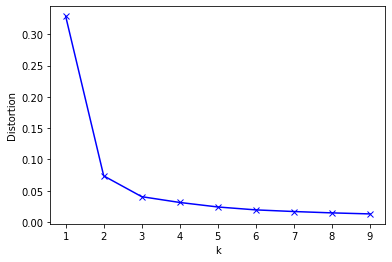

In [13]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

We can pick 2 clusters as it's the last point where we get significant difference in distortion (Elbow method)

In [14]:
kmeanModel = KMeans(n_clusters=2).fit(features_train[['long','lat']])

In [15]:
features_train['geo_cluster'] = kmeanModel.predict(features_train[['long','lat']])
features_test['geo_cluster'] = kmeanModel.predict(features_test[['long','lat']])

features_train_d = features_train.drop(['long','lat'], axis=1)
features_test_d = features_test.drop(['long','lat'], axis=1)

In [16]:
features_train_d = pd.get_dummies(features_train_d)
features_test_d = pd.get_dummies(features_test_d)

features_train_d = (features_train_d - features_train_d.mean()) / features_train_d.std()
features_test_d = (features_test_d - features_test_d.mean()) / features_test_d.std()

In [20]:
print(features_train_d.shape)
features_train_d.head()

(2418, 360)


,hectare_squirrel_number,running,chasing,climbing,eating,foraging,kuks,quaas,moans,tail_twitches,...,shift_AM,shift_PM,age_?,age_Adult,age_Juvenile,primary_fur_color_Black,primary_fur_color_Cinnamon,primary_fur_color_Gray,location_Above Ground,location_Ground Plane
226,1.875387,-0.559720,-0.324931,-0.53228,-0.584552,1.048095,-0.191997,-0.137679,-0.028766,-0.408558,...,1.113755,-1.113755,-0.035238,0.412683,-0.343283,5.512715,-0.387648,-2.128686,-0.621537,0.652972
2760,-1.003982,-0.559720,-0.324931,-0.53228,-0.584552,1.048095,-0.191997,-0.137679,-0.028766,-0.408558,...,1.113755,-1.113755,-0.035238,0.412683,-0.343283,-0.181324,2.578594,-2.128686,-0.621537,0.652972
1710,0.275738,-0.559720,-0.324931,-0.53228,-0.584552,1.048095,-0.191997,-0.137679,-0.028766,-0.408558,...,-0.897492,0.897492,-0.035238,0.412683,-0.343283,-0.181324,-0.387648,0.469579,-0.621537,0.652972
933,-0.684052,-0.559720,-0.324931,-0.53228,-0.584552,1.048095,-0.191997,-0.137679,-0.028766,-0.408558,...,-0.897492,0.897492,-0.035238,0.412683,-0.343283,-0.181324,-0.387648,0.469579,-0.621537,0.652972
2569,-1.003982,1.785867,-0.324931,-0.53228,-0.584552,-0.953717,-0.191997,-0.137679,-0.028766,-0.408558,...,1.113755,-1.113755,-0.035238,0.412683,-0.343283,-0.181324,-0.387648,0.469579,-0.621537,0.652972


In [21]:
features_train_d.columns[features_train_d.isna().any()].tolist()

['hectare_05H', 'hectare_13I', 'hectare_23E', 'hectare_41F', 'hectare_42B']

In [22]:
# change NaN to a bias (in the grand scheme of things this won't matter, its one/two entries in 3000)
for feature in features_train_d.columns[features_train_d.isna().any()].tolist():
    features_train_d[feature] = 1
    
for feature in features_test_d.columns[features_test_d.isna().any()].tolist():
    features_test_d[feature] = 1

In [23]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(features_train_d,target_train)
accuracy = lr.score(features_test_d,target_test)
print('test accuracy rate = ',accuracy.round(2))

test accuracy rate =  0.68


In [26]:
# Random forests grid search cross validation
# NOTE: This takes around 2-4 minutes to compute
rfgrid = {'max_depth':np.arange(20,40),'n_estimators':[500,1000,1500]}

rf = RandomForestClassifier()
rfCV = GridSearchCV(rf,param_grid=rfgrid,n_jobs=-1)
rfCV.fit(features_train_d,target_train)
print('optimal parameters',rfCV.best_params_)
print('optimal accuracy rate',rfCV.best_score_.round(2))

optimal parameters {'max_depth': 35, 'n_estimators': 1000}
optimal accuracy rate 0.72
